# Writing a VCell simulation dataset to Zarr

In [70]:
import tarfile
import os
from pathlib import Path
import zarr
from vcelldata.zarr_writer import write_zarr
from vcelldata.simdata_models import PdeDataSet, DataFunctions
import matplotlib.pyplot as plt

## extract the vcell simulation dataset from the tarball (compressed to save space)

In [71]:
test_data_dir = Path(os.getcwd()) / "test_data"

def extract_simdata() -> None:
    if (test_data_dir / "SimID_946368938_0_.log").exists():
        return
    with tarfile.open(test_data_dir / "SimID_946368938_simdata.tgz", 'r:gz') as tar:
        tar.extractall(path=test_data_dir)
        
extract_simdata()

display("./example_vcell_ui.png")

'./example_vcell_ui.png'

## read vcell simulation results metadata
* `PdeDataSet` contains the metadata for the tabular simulation results (e.g. state variables, shape, time points)
* `DataFunctions` contains the function definitions (name, expression, type, domain)
![vcell simulation results](./example_vcell_ui.png)

In [72]:
sim_id = 946368938
job_id = 0
pde_dataset = PdeDataSet(base_dir=test_data_dir, log_filename=f"SimID_{sim_id}_{job_id}_.log")
pde_dataset.read()
data_functions = DataFunctions(function_file=test_data_dir / f"SimID_{sim_id}_{job_id}_.functions")
data_functions.read()

## write the vcell simulation dataset to zarr including:
* metadata
* numerical datasets from stored data and evaluated functions
* ... masks for domains coming soon (e.g. cell, extracellular, etc.)

In [73]:
write_zarr(pde_dataset=pde_dataset, data_functions=data_functions, zarr_dir=test_data_dir / "zarr")

## Open and display slices from the zarr dataset as an image
* no masking for domains
* different colormap and scaling

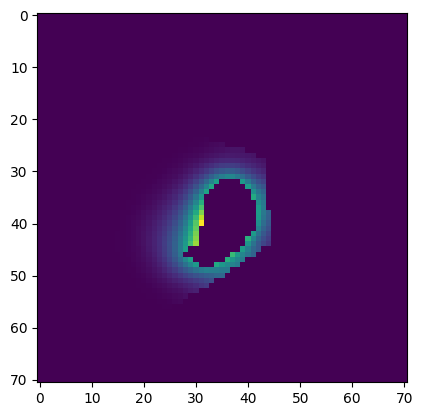

In [74]:
# Open the Zarr dataset
dataset = zarr.open(test_data_dir / "zarr", mode='r')

# Get a slice of the dataset, shape is (time, channel, z, y, x)
slice = dataset[3, 2, 9, :, :]

# Display the slice as an image
plt.imshow(slice)
plt.show()

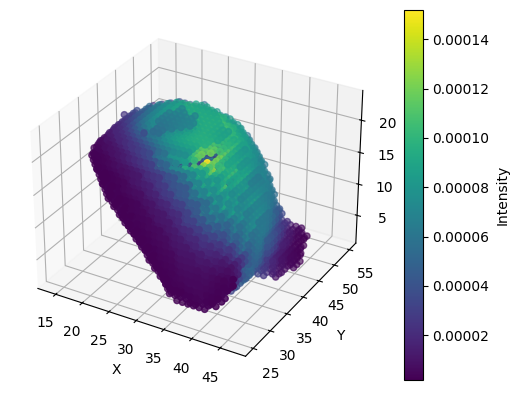

In [75]:
import numpy as np

# Select a 3D volume for a single time point and channel, shape is (z, y, x)
volume = dataset[3, 2, :, :, :]

# Create a figure for 3D plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a threshold to identify points of interest
threshold = volume.mean()  # Example: use the mean as a threshold

# Find indices where the intensity is above the threshold
z, y, x = np.where(volume > threshold)

# Get the intensity values for these points
intensities = volume[z, y, x]

# Create a 3D scatter plot
scatter = ax.scatter(x, y, z, c=intensities, cmap='viridis')

# Add a color bar to represent intensities
fig.colorbar(scatter, ax=ax, label='Intensity')

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()